In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_pickle('/content/drive/MyDrive/cv_fulldata_dec2020.pkl')

In [3]:
df.head()

,content,anger,fear,joy,none,sadness,uncertain,url,tag,visual_f,tag_f,feature
0,5h47LBNpbb6TAvl41O,0,0,0,0,1,0.0,https://giphy.com/gifs/Generali-Deutschland-in...,"{'movies': 0, 'tv': 0, 'cartoons & comics': 0,...","[0.04423453470916779, 0.009959404213202556, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,N4K0mbaJtwLgQ,1,0,0,0,0,0.0,https://giphy.com/gifs/no-john-oliver-N4K0mbaJ...,"{'movies': 0, 'tv': 0, 'cartoons & comics': 0,...","[0.03488446688546817, 0.013676315889161121, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,moXqsEVbHOQtG,0,0,0,0,1,1.0,https://giphy.com/gifs/black-and-white-dog-moX...,"{'movies': 0, 'tv': 0, 'cartoons & comics': 0,...","[0.012639926140571394, 0.019328883207623205, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,l2JJHiitHbK0hnbXO,0,1,0,0,1,1.0,https://giphy.com/gifs/syfy-sharks-sharknado-l...,"{'movies': 0, 'tv': 0, 'cartoons & comics': 0,...","[0.020821025840194362, 0.020494779066882123, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,3oEduQ3FsAU0YD1Gec,0,0,0,0,1,1.0,https://giphy.com/gifs/rupaulsdragraces5-tv-sh...,"{'movies': 0, 'tv': 0, 'cartoons & comics': 0,...","[0.03954229882019586, 0.011084108204927126, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
from PIL import Image
from PIL import ImageSequence
img = Image.open("/content/drive/MyDrive/giphy.gif")
i = 0
for frame in ImageSequence.Iterator(img):
    frame.save("frame%d.png" % i)
    i += 1

# **build i3d**

In [ ]:
!pip install dm-sonnet

     |████████████████████████████████| 256kB 12.5MB/s 


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sonnet as snt
import tensorflow as tf

In [ ]:
class Unit3D(snt.Module):
  """Basic unit containing Conv3D + BatchNorm + non-linearity."""

  def __init__(self, output_channels,
               kernel_shape=(1, 1, 1),
               stride=(1, 1, 1),
               activation_fn=tf.nn.relu,
               use_batch_norm=True,
               use_bias=False,
               name='unit_3d'):
    """Initializes Unit3D module."""
    super(Unit3D, self).__init__(name=name)
    self._output_channels = output_channels
    self._kernel_shape = kernel_shape
    self._stride = stride
    self._use_batch_norm = use_batch_norm
    self._activation_fn = activation_fn
    self._use_bias = use_bias

  def _build(self, inputs, is_training):
    """Connects the module to inputs.

    Args:
      inputs: Inputs to the Unit3D component.
      is_training: whether to use training mode for snt.BatchNorm (boolean).

    Returns:
      Outputs from the module.
    """
    net = snt.Conv3D(output_channels=self._output_channels,
                     kernel_shape=self._kernel_shape,
                     stride=self._stride,
                     padding=snt.SAME,
                     use_bias=self._use_bias)(inputs)
    if self._use_batch_norm:
      bn = snt.BatchNorm()
      net = bn(net, is_training=is_training, test_local_stats=False)
    if self._activation_fn is not None:
      net = self._activation_fn(net)
    return net

In [ ]:
class InceptionI3d(snt.Module):
  """Inception-v1 I3D architecture.

  The model is introduced in:

    Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
    Joao Carreira, Andrew Zisserman
    https://arxiv.org/pdf/1705.07750v1.pdf.

  See also the Inception architecture, introduced in:

    Going deeper with convolutions
    Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
    Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
    http://arxiv.org/pdf/1409.4842v1.pdf.
  """

  # Endpoints of the model in order. During construction, all the endpoints up
  # to a designated `final_endpoint` are returned in a dictionary as the
  # second return value.
  VALID_ENDPOINTS = (
      'Conv3d_1a_7x7',
      'MaxPool3d_2a_3x3',
      'Conv3d_2b_1x1',
      'Conv3d_2c_3x3',
      'MaxPool3d_3a_3x3',
      'Mixed_3b',
      'Mixed_3c',
      'MaxPool3d_4a_3x3',
      'Mixed_4b',
      'Mixed_4c',
      'Mixed_4d',
      'Mixed_4e',
      'Mixed_4f',
      'MaxPool3d_5a_2x2',
      'Mixed_5b',
      'Mixed_5c',
      'Logits',
      'Predictions',
  )

  def __init__(self, num_classes=400, spatial_squeeze=True,
               final_endpoint='Logits', name='inception_i3d'):
    """Initializes I3D model instance.

    Args:
      num_classes: The number of outputs in the logit layer (default 400, which
          matches the Kinetics dataset).
      spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
          before returning (default True).
      final_endpoint: The model contains many possible endpoints.
          `final_endpoint` specifies the last endpoint for the model to be built
          up to. In addition to the output at `final_endpoint`, all the outputs
          at endpoints up to `final_endpoint` will also be returned, in a
          dictionary. `final_endpoint` must be one of
          InceptionI3d.VALID_ENDPOINTS (default 'Logits').
      name: A string (optional). The name of this module.

    Raises:
      ValueError: if `final_endpoint` is not recognized.
    """

    if final_endpoint not in self.VALID_ENDPOINTS:
      raise ValueError('Unknown final endpoint %s' % final_endpoint)

    super(InceptionI3d, self).__init__(name=name)
    self._num_classes = num_classes
    self._spatial_squeeze = spatial_squeeze
    self._final_endpoint = final_endpoint

  def _build(self, inputs, is_training, dropout_keep_prob=1.0):
    """Connects the model to inputs.

    Args:
      inputs: Inputs to the model, which should have dimensions
          `batch_size` x `num_frames` x 224 x 224 x `num_channels`.
      is_training: whether to use training mode for snt.BatchNorm (boolean).
      dropout_keep_prob: Probability for the tf.nn.dropout layer (float in
          [0, 1)).

    Returns:
      A tuple consisting of:
        1. Network output at location `self._final_endpoint`.
        2. Dictionary containing all endpoints up to `self._final_endpoint`,
           indexed by endpoint name.

    Raises:
      ValueError: if `self._final_endpoint` is not recognized.
    """
    if self._final_endpoint not in self.VALID_ENDPOINTS:
      raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

    net = inputs
    end_points = {}
    end_point = 'Conv3d_1a_7x7'
    net = Unit3D(output_channels=64, kernel_shape=[7, 7, 7],
                 stride=[2, 2, 2], name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'MaxPool3d_2a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 1, 3, 3, 1], strides=[1, 1, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'Conv3d_2b_1x1'
    net = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                 name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'Conv3d_2c_3x3'
    net = Unit3D(output_channels=192, kernel_shape=[3, 3, 3],
                 name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'MaxPool3d_3a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 1, 3, 3, 1], strides=[1, 1, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_3b'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=96, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=16, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=32, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)

      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_3c'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=192, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=96, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'MaxPool3d_4a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1], strides=[1, 2, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4b'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=192, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=96, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=208, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=16, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=48, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4c'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=112, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=224, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=24, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4d'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=256, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=24, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4e'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=112, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=144, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=288, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4f'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=256, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=320, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'MaxPool3d_5a_2x2'
    net = tf.nn.max_pool3d(net, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_5b'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=256, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=320, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0a_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_5c'
    with tf.compat.v1.variable_scope(end_point):
      with tf.compat.v1.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=384, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=192, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=384, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=48, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.compat.v1.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Logits'
    with tf.compat.v1.variable_scope(end_point):
      # net = tf.nn.avg_pool3d(net, ksize=[1, 2, 7, 7, 1], 
      net = tf.nn.avg_pool3d(net, ksize=[1, 1, 7, 7, 1], 
      strides=[1, 1, 1, 1, 1], padding=snt.VALID)
      print(net) # Tensor("Flow/inception_i3d/Logits/AvgPool3D:0", shape=(1, 4, 1, 1, 1024), dtype=float32)
      # we need to store this net 
      
      # change 
      end_points['avg_pool3d'] = net #change according 
      
      net = tf.nn.dropout(net, dropout_keep_prob)
      logits = Unit3D(output_channels=self._num_classes,
                      kernel_shape=[1, 1, 1],
                      activation_fn=None,
                      use_batch_norm=False,
                      use_bias=True,
                      name='Conv3d_0c_1x1')(net, is_training=is_training)
      if self._spatial_squeeze:
        logits = tf.squeeze(logits, [2, 3], name='SpatialSqueeze')
    averaged_logits = tf.reduce_mean(logits, axis=1)
    end_points[end_point] = averaged_logits
    
    if self._final_endpoint == end_point: return averaged_logits, end_points
    

    end_point = 'Predictions'
    predictions = tf.nn.softmax(averaged_logits)
    end_points[end_point] = predictions
    return predictions, end_points

In [ ]:
net = InceptionI3d(400, spatial_squeeze=True, final_endpoint='Logits')

recover the weights from pretrained checkpoints

In [ ]:
tf.compat.v1.global_variables()

[]

In [ ]:
net.load_weights('/content/drive/MyDrive/rgb_i3d_checkpoint')

AttributeError: ignored

# **get extracted features**

In [4]:
import os
from tqdm import tqdm 

In [ ]:
files = os.listdir('/content/drive/MyDrive/GIPHY_rgb_features')

In [ ]:
len(files)

21424

In [ ]:
demo_file = files[10]

In [ ]:
feature = np.load('/content/drive/MyDrive/GIPHY_rgb_features/' + demo_file)

In [ ]:
feature.shape

(1, 1024)

In [ ]:
features = {}
for f in tqdm(files):
    feature = np.load('/content/drive/MyDrive/GIPHY_rgb_features/' + f)
    features[f] = feature

100%|██████████| 21424/21424 [2:24:45<00:00,  2.47it/s]


In [ ]:
import pickle
with open('/content/drive/MyDrive/features.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)


# **load features from drive**

In [5]:
import pickle
with open('/content/drive/MyDrive/features.pickle', 'rb') as handle:
    features = pickle.load(handle)

# **pad the sequence to the same length**

In [6]:
seqs = features.values()

In [7]:
l = [len(seq) for seq in seqs]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

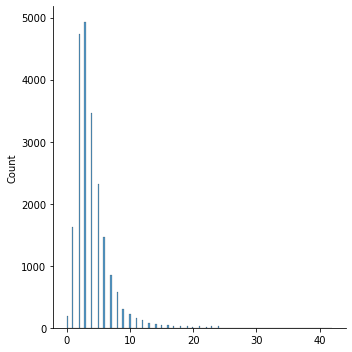

In [9]:
sns.displot(l)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


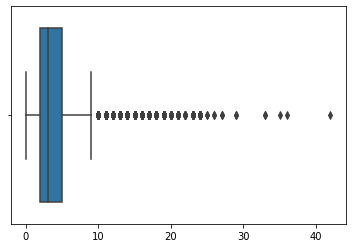

In [10]:
sns.boxplot(l)

In [11]:
max(l)

42

In [12]:
for f in features.keys():
    if len(features[f]) >= 10:
        features[f] = features[f][:10]
    else:
        features[f] = np.concatenate((features[f], np.zeros((10-features[f].shape[0], 1024))))

In [13]:
demo = np.array(list(features.values()))

In [14]:
df2 = pd.DataFrame({'content': list(features.keys()), 'features_timesteps': list(features.values())})

In [15]:
df2['content'] = df2['content'].apply(lambda s: s[:s.index('.')])

In [16]:
df2.head()

,content,features_timesteps
0,3orif2X665FMqzGEdq,"[[0.3025616705417633, 0.09759683161973953, 0.0..."
1,vuZeED6SoCN8MbLZq8,"[[0.5516777038574219, 0.5094824433326721, 0.21..."
2,l3vRjQtRTdY3GacGQ,"[[0.22382314503192902, 0.0, 0.1331664770841598..."
3,NYEAFHB94PZQI,"[[0.10112542659044266, 0.06395655125379562, 0...."
4,xUOwV7IC3267zT9iBW,"[[0.43979328870773315, 0.11720772832632065, 0...."


# **create a dataframe used as a training data set**

In [39]:
subset = df[['content','anger', 'fear', 'joy', 'sadness']]
trainset = subset.merge(df2, on='content', how='inner')

In [40]:
trainset.head()

,content,anger,fear,joy,sadness,features_timesteps
0,5h47LBNpbb6TAvl41O,0,0,0,1,"[[0.18471205234527588, 0.024927252903580666, 0..."
1,N4K0mbaJtwLgQ,1,0,0,0,"[[0.22143247723579407, 0.05100086331367493, 0...."
2,moXqsEVbHOQtG,0,0,0,1,"[[0.04298821836709976, 0.07614751905202866, 0...."
3,l2JJHiitHbK0hnbXO,0,1,0,1,"[[0.11309566348791122, 0.09070558845996857, 0...."
4,3oEduQ3FsAU0YD1Gec,0,0,0,1,"[[0.24229487776756287, 0.006197239272296429, 0..."


In [41]:
print(len(trainset), len(df2), len(subset))

12591 21424 19076


In [38]:
trainset.isnull().sum()

content                  0
anger                    0
fear                     0
joy                      0
sadness                  0
features_timesteps    6485
dtype: int64

In [19]:
subset.to_csv('/content/drive/MyDrive/lavender_CV_training_dataset.csv')

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(trainset, test_size = 0.3, shuffle=True)

In [21]:
print(train.shape, test.shape)

(8813, 6) (3778, 6)


In [22]:
train_x = np.array(list(train.features_timesteps.values))
train_y = np.array(list(train[['anger', 'fear', 'joy', 'sadness']].values))

test_x = np.array(list(test.features_timesteps.values))
test_y = np.array(list(test[['anger', 'fear', 'joy', 'sadness']].values))

# **Try to build a NN using LSTM**

In [23]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 43kB/s 


In [24]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import *

In [26]:
i = Input(shape = (10, 1024))
x =LSTM(128, return_sequences=False, return_state=False)(i)
x = Dense(32, activation='relu')(x)
o = Dense(4, activation='sigmoid')(x)
model = Model(i, o)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1024)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 594,596
Trainable params: 594,596
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy', optimizer='RMSprop')

In [31]:
history = model.fit(train_x, train_y, batch_size=16, epochs=200, verbose=1, validation_data=(test_x, test_y), validation_batch_size=16)

Epoch 1/200
551/551 [==============================] - 13s 24ms/step - loss: 0.4505 - val_loss: 0.4427
Epoch 2/200
551/551 [==============================] - 13s 23ms/step - loss: 0.4319 - val_loss: 0.4350
Epoch 3/200
551/551 [==============================] - 13s 23ms/step - loss: 0.4127 - val_loss: 0.4374
Epoch 4/200
551/551 [==============================] - 13s 24ms/step - loss: 0.3921 - val_loss: 0.4331
Epoch 5/200
551/551 [==============================] - 13s 23ms/step - loss: 0.3659 - val_loss: 0.4892
Epoch 6/200
551/551 [==============================] - 13s 24ms/step - loss: 0.3368 - val_loss: 0.4926
Epoch 7/200
551/551 [==============================] - 13s 24ms/step - loss: 0.3082 - val_loss: 0.4636
Epoch 8/200
551/551 [==============================] - 13s 24ms/step - loss: 0.2753 - val_loss: 0.5892
Epoch 9/200
551/551 [==============================] - 13s 24ms/step - loss: 0.2427 - val_loss: 0.5615
Epoch 10/200
551/551 [==============================] - 13s 24ms/step - l

KeyboardInterrupt: ignored